**<a href="https://colab.research.google.com/github/pyannote/pyannote-audio/blob/develop/tutorials/applying_a_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>**

# Applying a pretrained model

In this tutorial, you will learn how to apply `pyannote.audio` models on an audio file, whose manual annotation is depicted below

## Tutorial setup

In [3]:
# preparing notebook for visualization purposes
# (only show outputs between t=0s and t=30s)
from pyannote.core import notebook, Segment
notebook.crop = Segment(0, 30)

### `Google Colab` setup

If you are running this tutorial on `Colab`, execute the following commands in order to setup `Colab` environment. These commands will install `pyannote.audio`, and download resources used in this tutorial.

In [ ]:
!pip install -qq pyannote.audio==3.1.1
!pip install -qq ipython==7.34.0
!wget -q "https://github.com/pyannote/pyannote-audio/raw/develop/tutorials/assets/sample.wav"
!wget -q "https://github.com/pyannote/pyannote-audio/raw/develop/tutorials/assets/sample.rttm"
!wget -q -P ./assets/ "https://github.com/pyannote/pyannote-audio/blob/develop/tutorials/assets/download-model.png"

⚠ Restart the runtime (Runtime > Restart session).

In [18]:
AUDIO_FILE = "sample.wav"
REFERENCE = "sample.rttm"

### Non `Google Colab` setup

If you are not using Colab, clone `pyannote.audio` [GitHub repository](https://github.com/pyannote/pyannote-audio) and update ROOT_DIR accordingly

In [2]:
# clone pyannote-audio Github repository and update ROOT_DIR accordingly
ROOT_DIR = "<path-to-pyannote-github-repo>/pyannote-audio"
AUDIO_FILE = f"{ROOT_DIR}/tutorials/assets/sample.wav"
REFERENCE = f"{ROOT_DIR}/tutorials/assets/sample.rttm"

## References

First, let's take a look at the audio reference used in this tutorial. It can be accessed as follows:

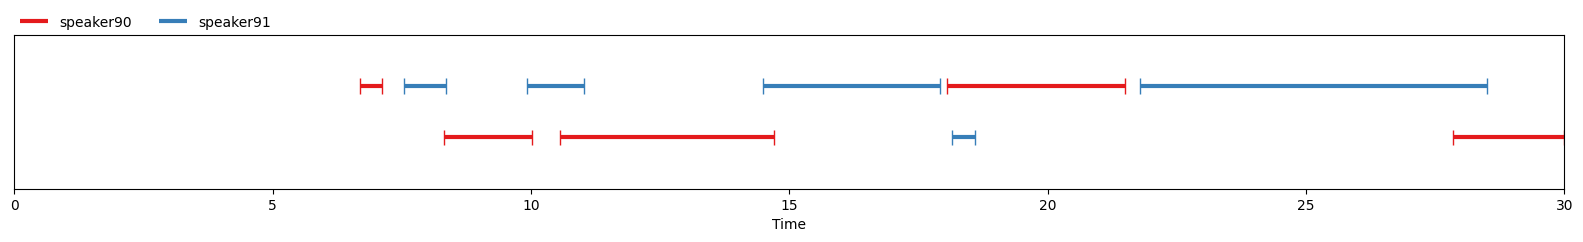

In [4]:
from pyannote.database.util import load_rttm

reference = load_rttm(REFERENCE)["sample"]
reference

## Loading models from 🤗 hub

A bunch of pretrained models are available on [🤗 Huggingface model hub](https://hf.co/models?other=pyannote-audio-model) and can be listed by looking for the [`pyannote-audio-model`](https://hf.co/models?other=pyannote-audio-model) tag.

In [5]:
from huggingface_hub import HfApi
available_models = [m.modelId for m in HfApi().list_models(filter="pyannote-audio-model")]
list(filter(lambda p: p.startswith("pyannote/"), available_models))

['pyannote/TestModelForContinuousIntegration',
 'pyannote/embedding',
 'pyannote/segmentation',
 'pyannote/brouhaha',
 'pyannote/segmentation-3.0',
 'pyannote/wespeaker-voxceleb-resnet34-LM']

Official [pyannote.audio](https://github.com/pyannote/pyannote-audio) models (i.e. those under the [`pyannote` organization](https://hf.co/pyannote) umbrella) are open-source, but gated. It means that you have to first accept users conditions on their respective Huggingface page to access the pretrained weights and hyper-parameters. Despite this initial process, those models can perfectly be downloaded for later offline use: keep reading this tutorial until the end to learn how to do that.

For instance, to load the speaker segmentation model used in this tutorial, you have to visit [hf.co/pyannote/segmentation](https://hf.co/pyannote/segmentation), accept the terms, and log in using `notebook_login` below:

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Once authenticated, you can load the model...

In [ ]:
from pyannote.audio import Model
model = Model.from_pretrained("pyannote/segmentation-3.0", use_auth_token=True)

... which consists in SincNet feature extraction (`sincnet`) , LSTM sequence modeling (`lstm`), a few feed-forward layers (`linear`), and a final multi-label `classifier`:

In [8]:
from pytorch_lightning.utilities.model_summary import summarize

summarize(model)

  | Name       | Type       | Params | In sizes       | Out sizes                                  
---------------------------------------------------------------------------------------------------------
0 | sincnet    | SincNet    | 42.6 K | [1, 1, 160000] | [1, 60, 589]                               
1 | lstm       | LSTM       | 1.4 M  | [1, 589, 60]   | [[1, 589, 256], [[8, 1, 128], [8, 1, 128]]]
2 | linear     | ModuleList | 49.4 K | ?              | ?                                          
3 | classifier | Linear     | 903    | [1, 589, 128]  | [1, 589, 7]                                
4 | activation | LogSoftmax | 0      | [1, 589, 7]    | [1, 589, 7]                                
---------------------------------------------------------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.893     Total estimated model params size (MB)

More details about the model are provided by its specifications...

In [9]:
specs = model.specifications
specs

Specifications(problem=<Problem.MONO_LABEL_CLASSIFICATION: 1>, resolution=<Resolution.FRAME: 1>, duration=10.0, min_duration=None, warm_up=(0.0, 0.0), classes=['speaker#1', 'speaker#2', 'speaker#3'], powerset_max_classes=2, permutation_invariant=True)

... which can be understood like that:

* `duration = 10.0`: the model ingests 10s-long audio chunks
* `Resolution.FRAME`:  the model output a sequence of frame-wise scores
* `len(classes) = 3`: model handle chunks with up to 3 speakers
* `powerset_max_classes = 2`: at most 2 speakers can talk at the same time (overlapped speech)
The previous two specifications give the classes that the model can predict: {no speech}, {spk1}, {spk2}, {spk3}, {spk1, spk2}, {spk1, spk3}, {spk2, spk3}, so a total of 7 classes.
More details about powerset can be found in the article `A. Plaquet and H. Bredin, “Powerset multi-class cross entropy loss for neural speaker diarization,” 2023.`, available [here](https://arxiv.org/abs/2310.13025).
* `Problem.MONO_LABEL_CLASSIFICATION`: the model prediction associates one class to each time frame

To apply the model on the audio file, we wrap it into an `Inference` instance:

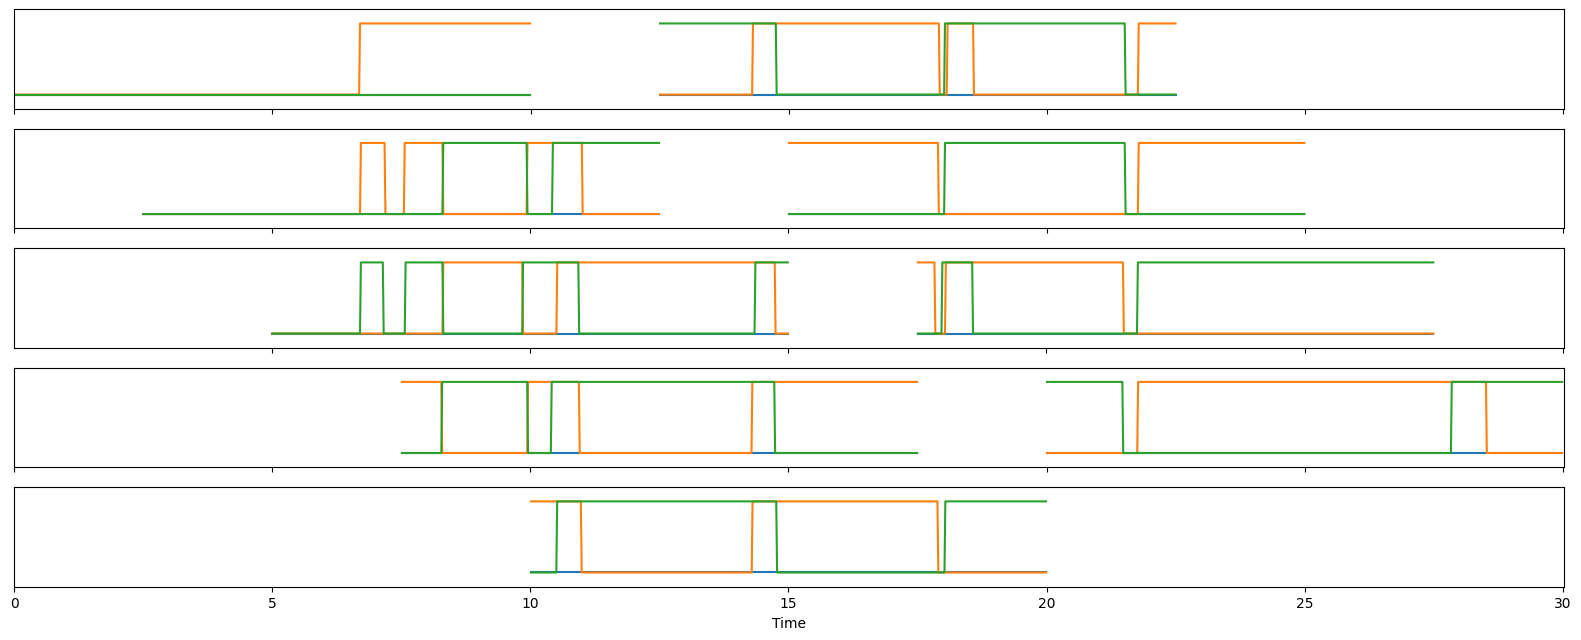

In [10]:
from pyannote.audio import Inference
inference = Inference(model, step=2.5)
output = inference(AUDIO_FILE)
output

For each of the 9 positions of the 10s window, the model outputs a 3-dimensional vector every 17ms (589 frames for 10 seconds), corresponding to the probabilities that each of (up to) 3 speakers is active.   

In [11]:
output.data.shape

(9, 589, 3)

## Processing a file from memory

In case the audio file is not stored on disk, pipelines can also process audio provided as a `{"waveform": ..., "sample_rate": ...}` dictionary.

In [12]:
import torchaudio
waveform, sample_rate = torchaudio.load(AUDIO_FILE)

print(f"{type(waveform)=}")
print(f"{waveform.shape=}")
print(f"{waveform.dtype=}")

audio_in_memory = {"waveform": waveform, "sample_rate": sample_rate}

type(waveform)=<class 'torch.Tensor'>
waveform.shape=torch.Size([1, 480000])
waveform.dtype=torch.float32


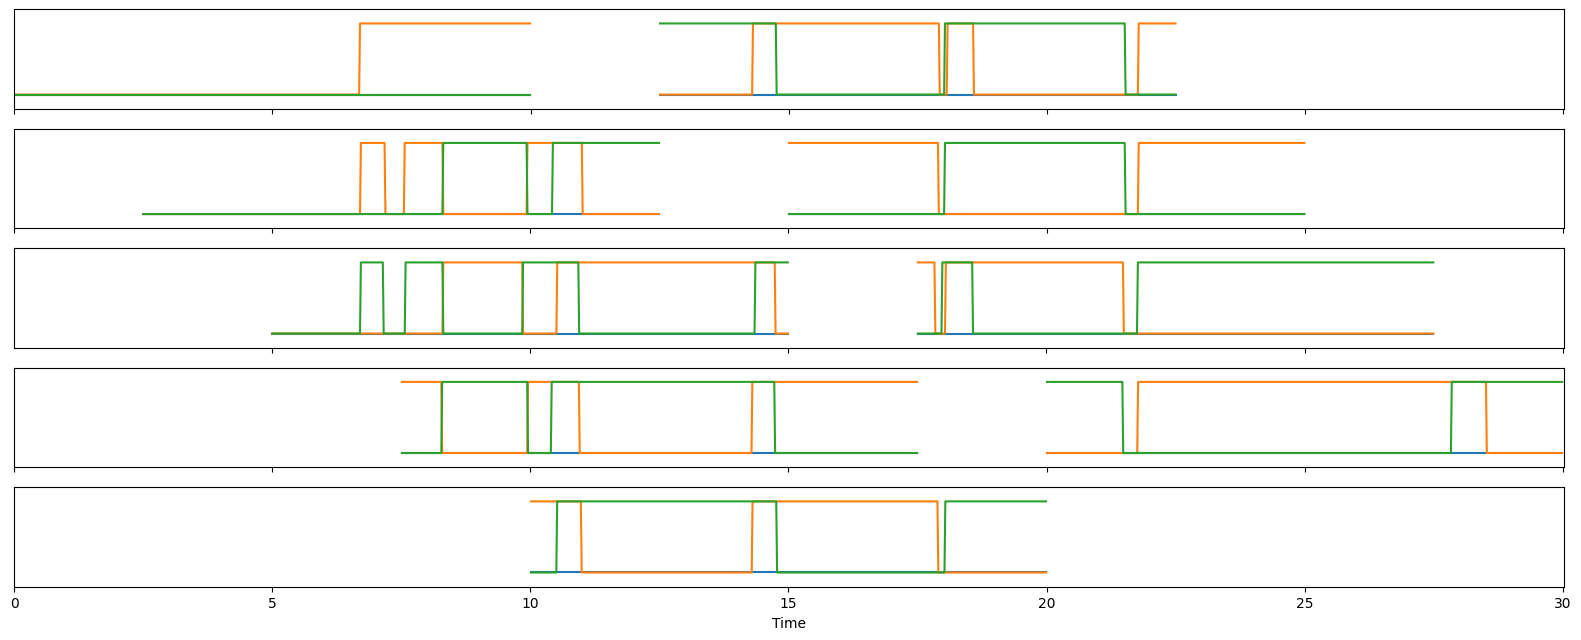

In [13]:
output = inference(audio_in_memory)
output

## Processing part of a file

If needed, `Inference` can be used to process only part of a file:

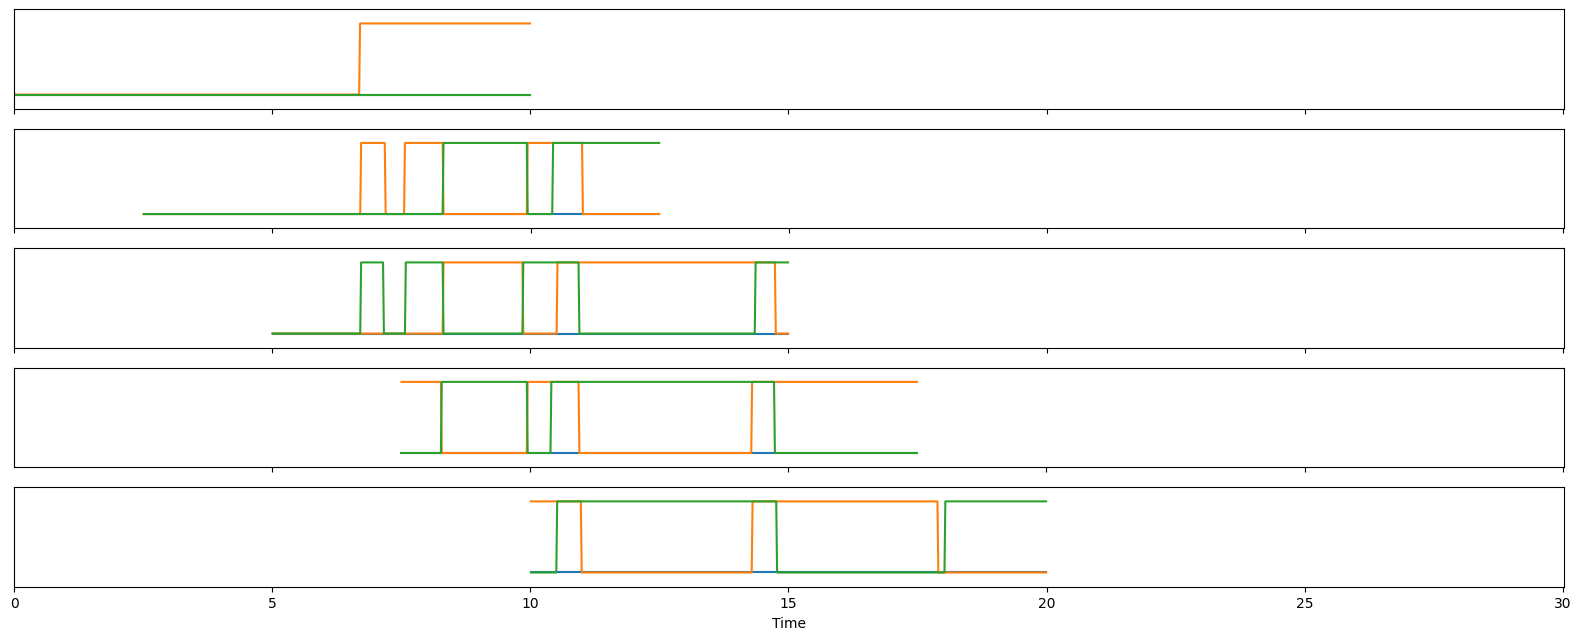

In [19]:
from pyannote.core import Segment
output = inference.crop(audio_in_memory, Segment(0, 20))
output

## Offline use

Gating models allows [me](https://herve.niderb.fr) to know a bit more about `pyannote.audio` user base and eventually help me write grant proposals to make `pyannote.audio` even better. Please fill this form as precisely as possible.

For instance, before gating `pyannote/segmentation`, I had no idea that so many people were relying on it in production. Hint: sponsors are more than welcome! maintaining open source libraries is time consuming.

That being said: this whole authentication process does not prevent you from using official `pyannote.audio` models offline (i.e. without going through the authentication process in every `docker run ...` or whatever you are using in production).

* Step 1: download the `pytorch_model.bin` model

![](assets/download-model.png)

* Step 2: load the model

In [ ]:
# look ma: no hands!
offline_model = Model.from_pretrained("pytorch_model.bin")

In [ ]:
# just checking weights are the same...
import torch
for weights, offline_weights in zip(model.parameters(), offline_model.parameters()):
    assert torch.equal(weights, offline_weights)